In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy

import random
import math
import os

In [2]:
SEED = 1

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [4]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

- include lengths in source

In [5]:
SRC = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True, include_lengths=True)
TRG = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(SRC, TRG))

In [10]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

- all this stuff

In [12]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size=BATCH_SIZE,
     sort_key = lambda x : len(x.src),
     sort_within_batch=True,
     device=device)

- encoder needs to accept lengths
- pack sequence before going into rnn
- unpack output before returning it

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src sent len, batch size]
        #src_len = [src sent len]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src sent len, batch size, emb dim]
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len)
        
        packed_outputs, hidden = self.rnn(packed_embedded)
               
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs = [sent len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        
        #outputs = [sent len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

- unchanged as mask is applied in decoder

In [14]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Parameter(torch.rand(dec_hid_dim))
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat encoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src sent len, dec hid dim]
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2))) 
        
        #energy = [batch size, src sent len, dec hid dim]
        
        energy = energy.permute(0, 2, 1)
        
        #energy = [batch size, dec hid dim, src sent len]
        
        #v = [dec hid dim]
        
        v = self.v.repeat(batch_size, 1).unsqueeze(1)
        
        #v = [batch size, 1, dec hid dim]
                
        attention = torch.bmm(v, energy).squeeze(1)
        
        #attention = [batch size, src sent len]
        
        return F.softmax(attention, dim=1)

- applies mask to attention output by decoder
- renormalizes attention so each row sums to 1 still
- returns attention

In [15]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        #mask = [batch size, src sent len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src sent len]
        
        #apply mask
        a = a * mask
        
        #re-normalize attention
        _sums = a.sum(1, keepdim=True)  #keepdim keeps tensor [batch size, 1] instead of making it [batch size]
        a = a.div(_sums) 
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src sent len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim=2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [sent len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #sent len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all(), print(output.shape, hidden.shape, output[0,0,:25], hidden[0,0,:25])
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        output = self.out(torch.cat((output, weighted, embedded), dim=1))
        
        #output = [bsz, output dim]
        
        return output, hidden.squeeze(0), a.squeeze(1)

- seq2seq needs to take in src_len, creates mask
- pass mask to decoder to be used in attn calculation
- receive attention from decoder and store in tensor and return it

In [16]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, sos_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.sos_idx = sos_idx
        self.device = device
        
    def create_mask(self, src_len):
        max_len = src_len.max()
        idxs = torch.arange(0,max_len).to(src_len.device)
        mask = (idxs<src_len.unsqueeze(1)).float()
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        
        #src = [src sent len, batch size]
        #src_len = [batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        if trg is None:
            assert teacher_forcing_ratio == 0, "Must be zero during inference"
            trg = torch.zeros((20, src.shape[1]), dtype=torch.long).fill_(self.sos_idx).to(src.device)
            
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #tensor to store attention
        attentions = torch.zeros(max_len, batch_size, src.shape[0]).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        output = trg[0,:]
        
        mask = self.create_mask(src_len)
                
        #mask = [batch size, src sent len]
                
        for t in range(1, max_len):
            output, hidden, attention = self.decoder(output, hidden, encoder_outputs, mask)
            outputs[t] = output
            attentions[t] = attention
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (trg[t] if teacher_force else top1)

        return outputs, attentions

In [17]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SOS_IDX = TRG.vocab.stoi['<sos>']

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SOS_IDX, device).to(device)

2


In [18]:
optimizer = optim.Adam(model.parameters())

In [19]:
pad_idx = TRG.vocab.stoi['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [20]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, src_len, trg)
        
        loss = criterion(output[1:].view(-1, output.shape[2]), trg[1:].view(-1))
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [21]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output, _ = model(src, src_len, trg, 0) #turn off teacher forcing

            loss = criterion(output[1:].view(-1, output.shape[2]), trg[1:].view(-1))

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [22]:
N_EPOCHS = 10
CLIP = 10
SAVE_DIR = 'models'
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'tut4_model.pt')

best_valid_loss = float('inf')

if not os.path.isdir(f'{SAVE_DIR}'):
    os.makedirs(f'{SAVE_DIR}')

for epoch in range(N_EPOCHS):
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
    
    print(f'| Epoch: {epoch+1:03} | Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | Val. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f} |')

| Epoch: 001 | Train Loss: 4.239 | Train PPL:  69.318 | Val. Loss: 3.720 | Val. PPL:  41.279 |
| Epoch: 002 | Train Loss: 3.088 | Train PPL:  21.938 | Val. Loss: 3.315 | Val. PPL:  27.523 |
| Epoch: 003 | Train Loss: 2.657 | Train PPL:  14.255 | Val. Loss: 3.290 | Val. PPL:  26.837 |
| Epoch: 004 | Train Loss: 2.366 | Train PPL:  10.651 | Val. Loss: 3.196 | Val. PPL:  24.442 |
| Epoch: 005 | Train Loss: 2.151 | Train PPL:   8.592 | Val. Loss: 3.264 | Val. PPL:  26.144 |
| Epoch: 006 | Train Loss: 1.998 | Train PPL:   7.373 | Val. Loss: 3.328 | Val. PPL:  27.875 |
| Epoch: 007 | Train Loss: 1.861 | Train PPL:   6.431 | Val. Loss: 3.361 | Val. PPL:  28.817 |
| Epoch: 008 | Train Loss: 1.777 | Train PPL:   5.914 | Val. Loss: 3.421 | Val. PPL:  30.606 |
| Epoch: 009 | Train Loss: 1.698 | Train PPL:   5.462 | Val. Loss: 3.360 | Val. PPL:  28.783 |
| Epoch: 010 | Train Loss: 1.613 | Train PPL:   5.019 | Val. Loss: 3.452 | Val. PPL:  31.571 |


In [23]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.225 | Test PPL:  25.149 |


In [43]:
def translate_sentence(sentence):
    tokenized = tokenize_de(sentence) #tokenize sentence
    tokenized = ['<sos>'] + [t.lower() for t in tokenized] + ['<eos>'] #add <sos> and <eos> tokens and lowercase
    numericalized = [SRC.vocab.stoi[t] for t in tokenized] #convert tokens into indexes
    sentence_length = torch.LongTensor([len(numericalized)]).to(device) #need sentence length for masking
    tensor = torch.LongTensor(numericalized).unsqueeze(1).to(device) #convert to tensor and add batch dimension
    translation_tensor_probs, attention = model(tensor, sentence_length, None, 0) #pass through model to get translation probabilities
    translation_tensor = torch.argmax(translation_tensor_probs.squeeze(1), 1) #get translation from highest probabilities
    translation = [TRG.vocab.itos[t] for t in translation_tensor][1:] #ignore the first token, just like we do in the training loop
    return translation, attention[1:] #ignore first attention array

In [ ]:
def display_attention(candidate, translation, attention):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    translation = translation[:translation.index('<eos>')] #cut translation after first <eos> token
    attention = attention[:len(translation)].squeeze(1).cpu().detach().numpy() #cut attention to same length as translation
    cax = ax.matshow(attention, cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + ['<sos>'] + [t.lower for t in tokenize_de(candidate)] + ['<eos>'], rotation=90)
    ax.set_yticklabels([''] + translation)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [51]:
candidate = ' '.join(vars(train_data.examples[0])['src'])
candidate_translation = ' '.join(vars(train_data.examples[0])['trg'])

print(candidate)
print(candidate_translation)

zwei junge weiße männer sind im freien in der nähe vieler büsche .
two young , white males are outside near many bushes .


['two', 'young', 'white', 'males', 'are', 'outside', 'near', 'near', 'bushes', '.', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>']


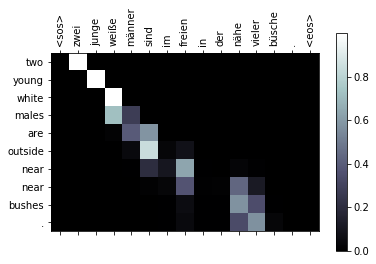

In [52]:
translation, attention = translate_sentence(candidate)

print(translation)

display_attention(candidate, translation, attention)

In [53]:
candidate = ' '.join(vars(valid_data.examples[0])['src'])
candidate_translation = ' '.join(vars(valid_data.examples[0])['trg'])

print(candidate)
print(candidate_translation)

eine gruppe von männern lädt baumwolle auf einen lastwagen
a group of men are loading cotton onto a truck


['a', 'group', 'of', 'men', 'loading', 'loading', 'a', 'truck', '.', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>']


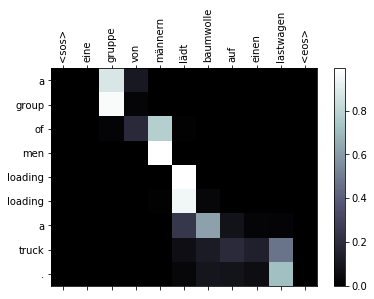

In [54]:
translation, attention = translate_sentence(candidate)

print(translation)

display_attention(candidate, translation[:translation.index('<eos>')], attention)

In [55]:
candidate = ' '.join(vars(test_data.examples[0])['src'])
candidate_translation = ' '.join(vars(test_data.examples[0])['trg'])

print(candidate)
print(candidate_translation)

ein mann mit einem orangefarbenen hut , der etwas anstarrt .
a man in an orange hat starring at something .


['a', 'man', 'wearing', 'an', 'orange', 'hat', 'is', 'something', 'something', 'something', 'something', 'something', '.', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>']


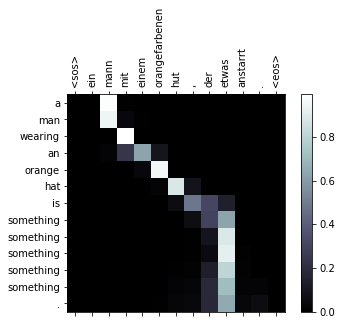

In [56]:
translation, attention = translate_sentence(candidate)

print(translation)

display_attention(candidate, translation[:translation.index('<eos>')], attention)